In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,04-01-2019,210.60,214.90,210.00,213.50,213.80,1213181,2583.05
1,03-01-2019,214.95,215.35,209.90,210.55,210.05,2096553,4433.50
2,02-01-2019,219.00,220.35,213.60,214.20,214.60,1081778,2340.31
3,01-01-2019,219.95,221.05,218.05,218.95,219.10,716275,1571.63
4,31-12-2018,222.00,223.65,218.85,219.55,219.40,965858,2131.09


# **Analyze the closing prices from dataframe**

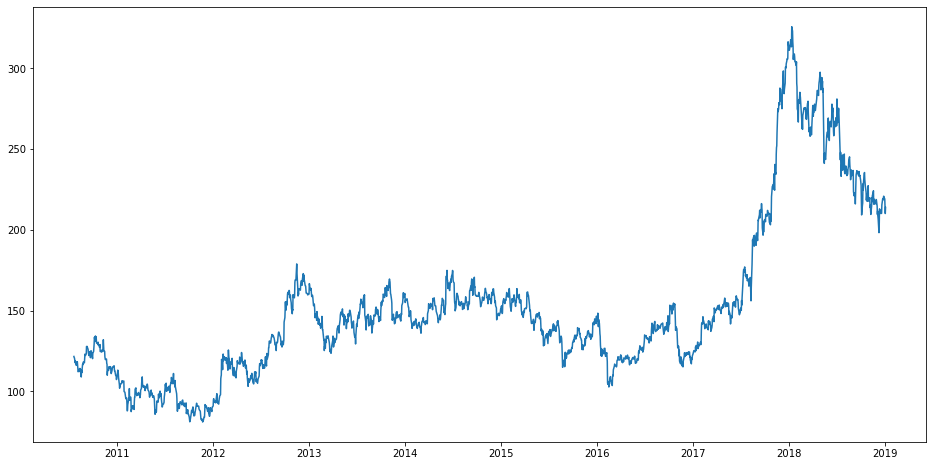

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%d-%m-%Y")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='close price history')

# **Sort the dataset on date time and filter “Date” and “Close” columns**

In [4]:
data=df.sort_index(ascending=True)

new_Dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
  new_Dataset["Date"][i]=data['Date'][i]
  new_Dataset["Close"][i]=data['Close'][i]
new_Dataset

,Date,Close
0,2010-07-21 00:00:00,121.55
1,2010-07-22 00:00:00,120.9
2,2010-07-23 00:00:00,120.65
3,2010-07-26 00:00:00,117.6
4,2010-07-27 00:00:00,118.65
...,...,...
2095,2018-12-31 00:00:00,219.4
2096,2019-01-01 00:00:00,219.1
2097,2019-01-02 00:00:00,214.6
2098,2019-01-03 00:00:00,210.05


# **Normalize the new filtered dataset**

In [5]:

df.describe()


,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2.100000e+03,2100.000000
mean,151.818810,154.145190,149.361619,151.584762,151.561595,2.327641e+06,3919.237300
std,49.350352,50.127368,48.597083,49.420366,49.401844,2.081348e+06,4547.900775
min,81.100000,82.800000,80.000000,81.000000,80.950000,3.961000e+04,37.040000
25%,120.750000,122.675000,119.000000,120.600000,120.550000,1.147086e+06,1462.815000
50%,142.250000,144.300000,140.425000,142.000000,141.950000,1.768579e+06,2552.165000
75%,159.000000,161.500000,156.825000,158.712500,158.762500,2.795726e+06,4548.082500
max,327.700000,328.750000,321.650000,325.950000,325.750000,2.919102e+07,55755.080000


In [6]:


final_Dataset=new_Dataset.values
train_Data=final_Dataset[0:980,:]  #Selected starting 980 rows in training set
valid_Data=final_Dataset[980:,:] #Selected after 980 rows in testing set

new_Dataset.index=new_Dataset.Date
new_Dataset.drop("Date",axis=1,inplace=True)
final_Dataset=new_Dataset.values
scaler=MinMaxScaler(feature_range=(0,1))
scaled_Data=scaler.fit_transform(final_Dataset) # normalized the dataset between the range 0 to 1.

x_Train_Data,y_Train_Data=[],[]

for i in range(60,len(train_Data)):             # starting from 60th row to lenght of data (so that random values can be picked)
  x_Train_Data.append(scaled_Data[i-60:i,0]) #data[60:0,0]  (First 60 rows , 1st col)
  y_Train_Data.append(scaled_Data[i,0])         ##nly 60th value

x_Train_Data,y_Train_Data=np.array(x_Train_Data),np.array(y_Train_Data)
x_Train_Data=np.reshape(x_Train_Data,(x_Train_Data.shape[0],x_Train_Data.shape[1],1))

# **Build and train the LSTM model**

In [10]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_Train_Data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_Dataset[len(new_Dataset)-len(valid_Data)-60:].values   
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)          # Normalization of test dataset

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_Train_Data,y_Train_Data,epochs=1,batch_size=1,verbose=2)


920/920 - 19s - loss: 9.5073e-04


# Take a sample of a dataset to make stock price predictions using the LSTM model

In [14]:
x_test=[]
for i in range(60,inputs_data.shape[0]):
  x_test.append(inputs_data[i-60:i,0])

x_test=np.array(x_test)

x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
predicted_Closing_price=lstm_model.predict(x_test)
predicted_Closing_price=scaler.inverse_transform(predicted_Closing_price)

## **Visualize the predicted stock costs with actual stock costs**

<ipython-input-15-f957b9485107>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_Data['predictions']=predicted_Closing_price


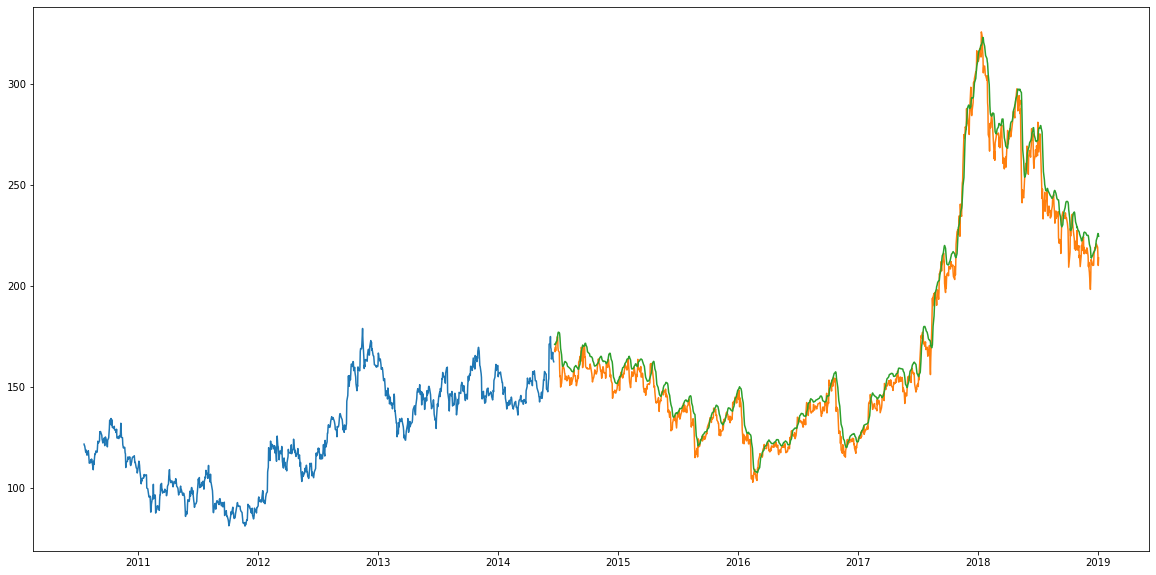

In [15]:
train_Data=new_Dataset[:980]
valid_Data=new_Dataset[980:]
valid_Data['predictions']=predicted_Closing_price
plt.plot(train_Data["Close"])
plt.plot(valid_Data[['Close',"predictions"]])

In [11]:
m=lstm_model.predict(x_test)[:10]

In [12]:
x_test[0][:10]

array([[0.25285948],
       [0.25306373],
       [0.25245098],
       [0.24857026],
       [0.27389706],
       [0.28227124],
       [0.2994281 ],
       [0.29636438],
       [0.28839869],
       [0.29105392]])

In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(x_test[0][1], m[1])

0.0018749765270316575

In [14]:
for i in range(len(m)):
    p=mean_squared_error(x_test[0][i], m[i])
    print(p)

0.0019459389170471784
0.0018749765270316575
0.0019777217936418337
0.0025533972070730312
0.000734285075074796
0.000477563779238701
7.710730022678563e-05
0.00028402436467383254
0.000864190680356462
0.0007858082998190717


In [25]:
m

array([[0.29697227],
       [0.29636472],
       [0.29692256],
       [0.2991014 ],
       [0.30099475],
       [0.30412447],
       [0.30820918],
       [0.3132174 ],
       [0.3177958 ],
       [0.3190862 ]], dtype=float32)